In [1]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

In [2]:
from matplotlib import pyplot as plt
import numpy as np
from keras.models import load_model
from keras import backend as K
import keras
import tensorflow as tf

Using TensorFlow backend.


In [3]:
model = load_model("./saved_model/model.h5")
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 2048)              6293504   
_________________________________________________________________
dense_7 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
dense_8 (Dense)              (None, 10)                20490     
Total params: 10,510,346
Trainable params: 10,510,346
Non-trainable params: 0
_________________________________________________________________


In [4]:
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [5]:
x_train = x_train/255.0
x_test = x_test/255.0
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
x_train = (x_train - mean)/std
x_test = (x_test - mean)/std

In [6]:
y_pred = model.predict(x_test, batch_size=64)
y_pred = np.argmax(np.squeeze(y_pred), axis=1)
y_test = np.squeeze(y_test)
acc = sum(y_pred == y_test)/len(y_test)
print("Test accuracy: " + str(acc))

Test accuracy: 0.5076


In [7]:
class AdversarialAttack(object):
    def __init__(self, model, loss_func, epsilon=0.0):
        self._loss_func = loss_func
        self._epsilon = epsilon
        self._model = keras.models.clone_model(model)

        self._model.trainable = False
        self._model.compile(optimizer=model.optimizer, loss=self._loss_func)

        self.getFGSMTensor()

    def getFGSMTensor(self):
        self.label = K.placeholder(shape=self._model.output.get_shape())
        self.loss = self._loss_func(self.label, self._model.output)
        self.normed_grads = K.sign(K.gradients(self.loss, self._model.input)[0])
        self.iterate = K.function([self._model.input, self.label], [self.loss, self.normed_grads])

    def getWeights(self, model):
        self._model.set_weights(model.get_weights())

    def fgsmGrad(self, x, y, model):
        self.getWeights(model)
        loss_value, adv_grad = self.iterate([x, y.astype('float32')])
        return adv_grad

    def fgsm(self, x, y, model, epsilon=None):
        adv_grad = self.fgsmGrad(x, y, model)
        if epsilon:
            x_adv = x+epsilon*adv_grad
        else:
            x_adv = x+self._epsilon*adv_grad
        return x_adv

In [8]:
loss_func = keras.losses.sparse_categorical_crossentropy
adv_class = AdversarialAttack(model, loss_func)

In [30]:
epsilon = 0.1
x_origin = x_test[8][np.newaxis, :]
y_origin = y_test[8]
y_pred = np.squeeze(np.argmax(model.predict(x_origin), axis=1))

loss_origin = tf.Session().run(loss_func(tf.convert_to_tensor(y_origin), 
                                 tf.convert_to_tensor(model.predict(x_origin))))[0]

x_adv = adv_class.fgsm(x_origin, y_origin, model, epsilon)
y_adv = np.squeeze(np.argmax(model.predict(x_adv), axis=1))
loss_adv = tf.Session().run(loss_func(tf.convert_to_tensor(y_origin), 
                                 tf.convert_to_tensor(model.predict(x_adv))))[0]

print("Loss for prediction of the original image: " + str(loss_origin))
print("Loss for prediction of the adversarial image: " + str(loss_adv))

Loss for prediction of the original image: 0.90025693
Loss for prediction of the adversarial image: 1.7781217


(-0.5, 31.5, 31.5, -0.5)

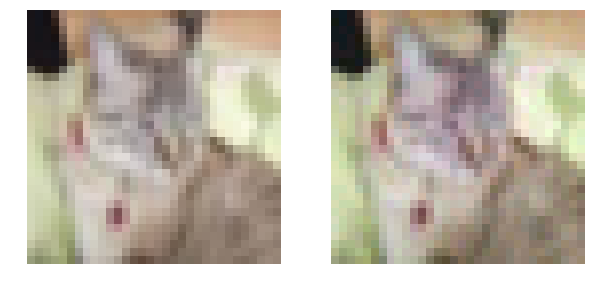

In [31]:
x_origin_img = np.clip((np.squeeze(x_origin)*std+mean)*255.0, 0, 255).astype(np.int32)
x_adv_img = np.clip((np.squeeze(x_adv)*std+mean)*255.0, 0, 255).astype(np.int32)
plt.figure(figsize=(10, 10))
plt.subplot(121)
plt.imshow(x_origin_img)
plt.axis('off')
plt.subplot(122)
plt.imshow(x_adv_img)
plt.axis('off')

In [36]:
# Label from 0-9:
# ['airplane', 'automobile', 'bird', 'cat', 'deer',
#  'dog', 'frog', 'horse', 'ship', 'truck']

print("The truth label is: " + str(y_origin))
print("Predicted label of the original image: " + str(y_pred))
print("Predicted label of the adversarial image: "+ str(y_adv))

The truth label is: 3
Predicted label of the original image: 3
Predicted label of the adversarial image: 7


In [12]:
y_adv_all = []
for i in range(len(y_test)):
    x_origin = x_test[i][np.newaxis, :]
    y_origin = y_test[i]
    x_adv = adv_class.fgsm(x_origin, y_origin, model, epsilon)
    y_adv = np.squeeze(np.argmax(model.predict(x_adv), axis=1))
    y_adv_all.append(y_adv)

In [13]:
y_test = np.squeeze(y_test)
acc_adv = sum(y_adv_all == y_test)/len(y_test)
print("Test accuracy for original images: " + str(acc))
print("Test accuracy for adversarial images: " + str(acc_adv))

Test accuracy for original images: 0.5076
Test accuracy for adversarial images: 0.1166
